In [82]:
import oceanspy as ospy
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.colors import Normalize
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.colors import SymLogNorm

In [83]:
# Import of data
mooring_shelfExtended_kogur = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/mooring_shelfExtended_kogur.nc')
mooring_shelfExtended = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/mooring_shelfExtended.nc')
mooring_kogur = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/mooring_kogur.nc')
mooring_north = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/mooring_north_new.nc')
depth = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/Depth_res.nc')['Depth'].sel(Y=slice(66,77)).sel(X=slice(-30,10))
depth_no_nan = depth

FW_input = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/oceFWflx.nc')['oceFWflx'].sel(Y=slice(66,77)).sel(X=slice(-30,10))

area = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/rA.nc')['rA'].sel(Y=slice(66,77)).sel(X=slice(-30,10))
depth = depth.where(depth > 0, np.nan)

# Save and load config

In [84]:
# Config for saving or loading data, created to save time when running the script. Must have been runned once before or the needed datafiles!

config_save_masked_area = False # Set True if changes to mask is applied
config_save_FWT = False # Set True if changes to advective transport is made


In [85]:
# Due to changes from 78.5N to 76N for the northern boundary, the lenght needs to be fixed

pos_Extended = []
for mooring in mooring_shelfExtended['mooring']:
    if mooring_shelfExtended.YC[mooring][0][0] > 75.992 and mooring_shelfExtended.YC[mooring][0][0] < 76.008:
        # print(mooring.values)
        pos_Extended.append(mooring.values)


pos_north = []
for mooring in mooring_north['mooring']:
    test = depth_no_nan.sel(X=mooring_north.XC[mooring][0][0].values).sel(Y=mooring_north.YC[mooring][0][0].values).values
    if test <= 0:
        pos_north.append(mooring.values)

<xarray.Dataset>
Dimensions:            (Z: 216, Zp1: 217, Zu: 216, Zl: 216, mooring: 938, Y: 1,
                        X: 1, Yp1: 2, Xp1: 2, time: 1460, time_midp: 1459,
                        mooring_midp: 1053)
Coordinates: (12/29)
  * Z                  (Z) float64 -1.0 -3.5 -7.0 ... -3.922e+03 -3.942e+03
  * Zp1                (Zp1) float64 0.0 -2.0 -5.0 ... -3.932e+03 -3.951e+03
  * Zu                 (Zu) float64 -2.0 -5.0 -9.0 ... -3.932e+03 -3.951e+03
  * Zl                 (Zl) float64 0.0 -2.0 -5.0 ... -3.913e+03 -3.932e+03
    drF                (Z) float64 ...
    XC                 (mooring, Y, X) float64 ...
    ...                 ...
  * Y                  (Y) int64 0
  * Xp1                (Xp1) int64 0 1
  * Yp1                (Yp1) int64 0 1
    mooring_dist       (mooring) float64 ...
  * mooring_midp       (mooring_midp) float64 0.5 1.5 ... 1.052e+03 1.052e+03
    mooring_midp_dist  (mooring_midp) float64 ...
Data variables:
    U                  (time, Z, mooring, Y, Xp1) float64 ...
    V                  (time, Z, mooring, Yp1, X) float64 ...
    Temp               (time, Z, mooring, Y, X) float64 ...
    S                  (time, Z, mooring, Y, X) float64 ...
Attributes: (12/24)
    MITgcm_version:          checkpoint67l
    build_user:              malmans2@jhu.edu
    build_host:              compute0673
    build_date:              Fri Nov  8 01:36:45 EST 2019
    MITgcm_URL:              http://mitgcm.org
    MITgcm_tag_id:           
    ...                      ...
    OceanSpy_parameters:     {'rSphere': 6371.0, 'eq_state': 'mdjwf', 'rho0':...
    OceanSpy_name:           IGPyearlong
    OceanSpy_description:    High-resolution numerical simulation carried out...
    OceanSpy_projection:     Mercator(**{})
    OceanSpy_grid_coords:    {'Y': {'Y': None, 'Yp1': 0.5}, 'X': {'X': None, ...
    OceanSpy_grid_periodic:  []

Text(0.5, 1.0, 'Masked Data')

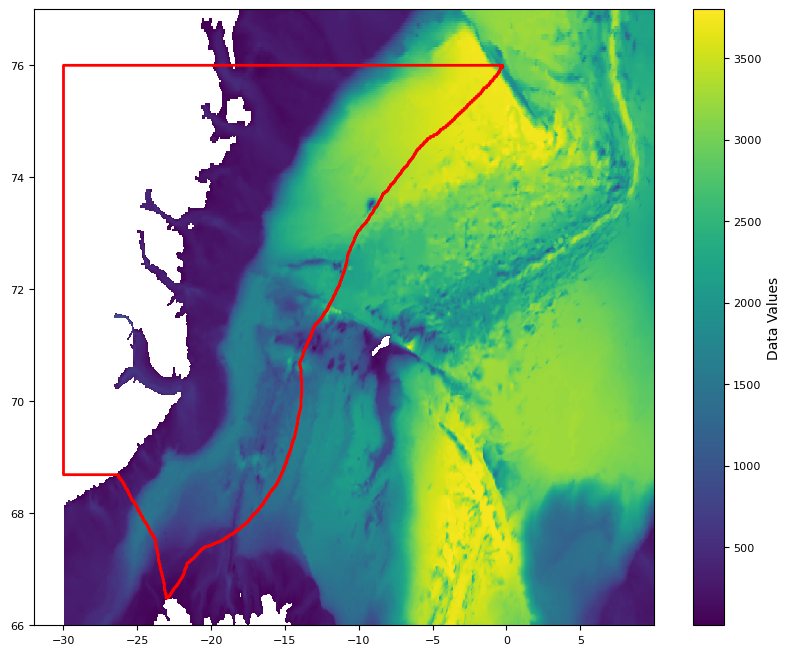

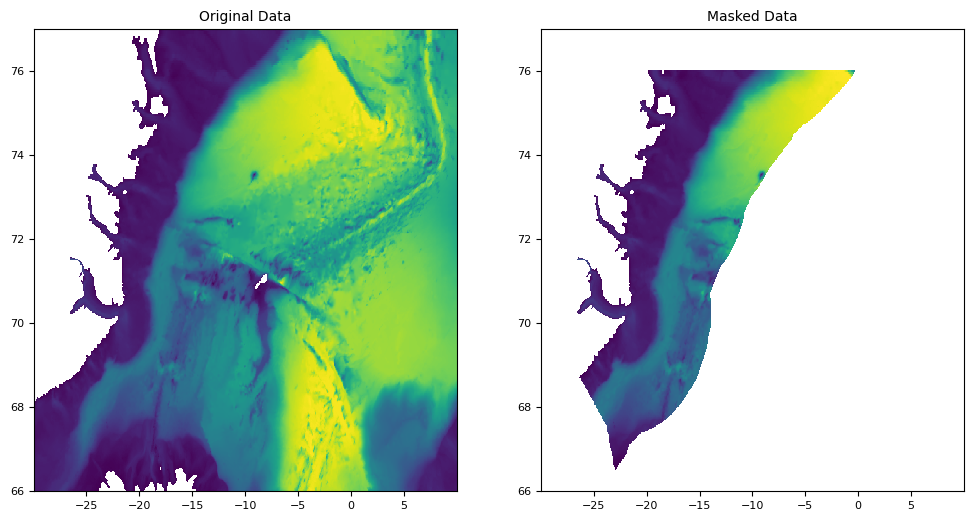

In [86]:
# Defining the interior domain based on the defined boundaries

cond = mooring_north ==  mooring_north.XC <= mooring_shelfExtended.XC[pos_Extended[-1]][0][0].values
mooring_north = mooring_north.where(cond,drop=True)

mooring_north = mooring_north.sel(mooring=slice(23,mooring_north.mooring[-1].values))

mooring_shelfExtended = mooring_shelfExtended.sel(mooring=slice(pos_Extended[-1],mooring_shelfExtended.mooring[-1].values))
display(mooring_shelfExtended)

XC_north = [mooring_north["XC"][x-23].values[0][0] for x in mooring_north['mooring']]
YC_north = [mooring_north["YC"][x-23].values[0][0] for x in mooring_north['mooring']]

XC_east1 = [mooring_shelfExtended["XC"][x-pos_Extended[-1]].values[0][0] for x in mooring_shelfExtended['mooring']]
YC_east1 = [mooring_shelfExtended["YC"][x-pos_Extended[-1]].values[0][0] for x in mooring_shelfExtended['mooring']]
XC_east2 = [mooring_shelfExtended_kogur["XC"][x].values[0][0] for x in mooring_shelfExtended_kogur['mooring']]
YC_east2 = [mooring_shelfExtended_kogur["YC"][x].values[0][0] for x in mooring_shelfExtended_kogur['mooring']]

XC_south = [mooring_kogur["XC"][x].values[0][0] for x in mooring_kogur['mooring']]
YC_south = [mooring_kogur["YC"][x].values[0][0] for x in mooring_kogur['mooring']]

# Define western boundary coordinates (example coordinates, replace with actual)
XC_west = [-30] * len(np.linspace(YC_south[0], YC_north[0], 100))  # Replace with actual western boundary X coordinates
YC_west = np.linspace(YC_south[0], YC_north[0], 100)  # Replace with actual western boundary Y coordinates

# Combine boundary coordinates into a single list of tuples
boundary_coords = list(zip(XC_north, YC_north)) + \
                  list(zip(XC_east1, YC_east1)) + \
                  list(zip(XC_east2, YC_east2)) + \
                  list(zip(XC_south[::-1], YC_south[::-1])) + \
                  list(zip(XC_west, YC_west))

data = depth

# Create a Path object from the boundary coordinates
boundary_path = Path(boundary_coords)

# Plot the data and the boundary path
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the data
pcm = ax.pcolormesh(data.XC, data.YC, data, shading='auto', cmap='viridis')
fig.colorbar(pcm, ax=ax, label='Data Values')

# Plot the boundary path
boundary_coords.append(boundary_coords[0])  # Close the polygon
boundary_lon, boundary_lat = zip(*boundary_coords)
ax.plot(boundary_lon, boundary_lat, 'r-', linewidth=2, label='Boundary Path')

# Create a mask based on whether points are inside the boundary path
mask = np.zeros(data.shape, dtype=bool)
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        point = (data.XC[i, j], data.YC[i, j])
        if not boundary_path.contains_point(point):
            mask[i, j] = True

# Apply the mask to the data
masked_data = data.where(~mask)

# Plot the original and masked data
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Original data
ax[0].pcolormesh(data.XC, data.YC, data, shading='auto')
ax[0].set_title('Original Data')

# Masked data
ax[1].pcolormesh(data.XC, data.YC, masked_data, shading='auto')
ax[1].set_title('Masked Data')

In [87]:
display(XC_north[100],YC_north[100])

-15.073069799999985

75.99466384499999

In [88]:
# Test if first mask has removed the data from the boundary array
test = depth.where(~mask)
print(test.sel(X=-15.073069799999985).sel(Y=75.99466384499999))

<xarray.DataArray 'Depth' ()>
array(221.29407557)
Coordinates:
    X        float64 -15.07
    Y        float64 75.99
    XC       float64 -15.07
    YC       float64 75.99
Attributes:
    description:    fluid thickness in r coordinates (at rest)
    standard_name:  ocean_depth
    long_name:      ocean depth
    units:          m
    coordinate:     XC YC


In [89]:
# Remove overlap from the interior domain with the boundaries

XC_mask = XC_north + XC_east1 + XC_east2 + XC_south

YC_mask = YC_north + YC_east1 + YC_east2 + YC_south

# Ensure the lists are the same length
assert len(XC_mask) == len(YC_mask), "XC_mask and YC_mask must be the same length"

mask2_cond = depth.where(~mask)
cond_bound = xr.ones_like(mask2_cond, dtype=bool)

for x, y in zip(XC_mask, YC_mask):
    cond_bound.loc[{"X": x, "Y": y}] = False


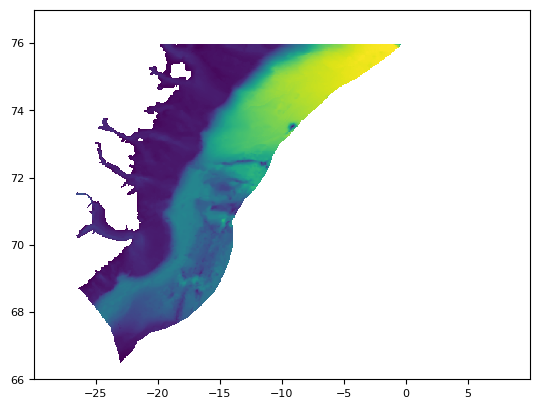

In [90]:
mask2_cond_ = mask2_cond.where(cond_bound)
fig, ax = plt.subplots()
ax.pcolormesh(mask2_cond_.X,mask2_cond_.Y,mask2_cond_)

<xarray.DataArray 'Depth' ()>
array(221.29407557)
Coordinates:
    X        float64 -15.07
    Y        float64 75.99
    XC       float64 -15.07
    YC       float64 75.99
Attributes:
    description:    fluid thickness in r coordinates (at rest)
    standard_name:  ocean_depth
    long_name:      ocean depth
    units:          m
    coordinate:     XC YC


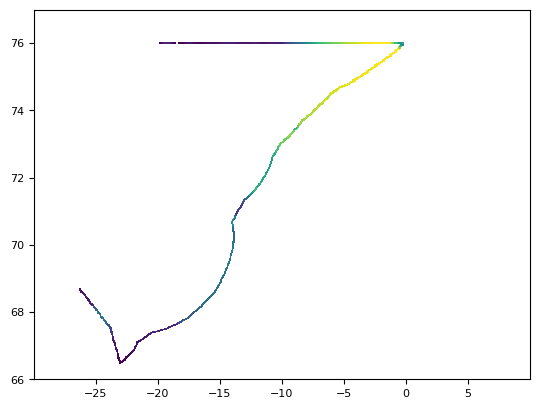

In [91]:
# See if the new mask removes boundary array location
test = depth.where(~cond_bound)
print(test.sel(X=-15.073069799999985).sel(Y=75.99466384499999))
fig, ax = plt.subplots()
ax.pcolor(test.X,test.Y,test)

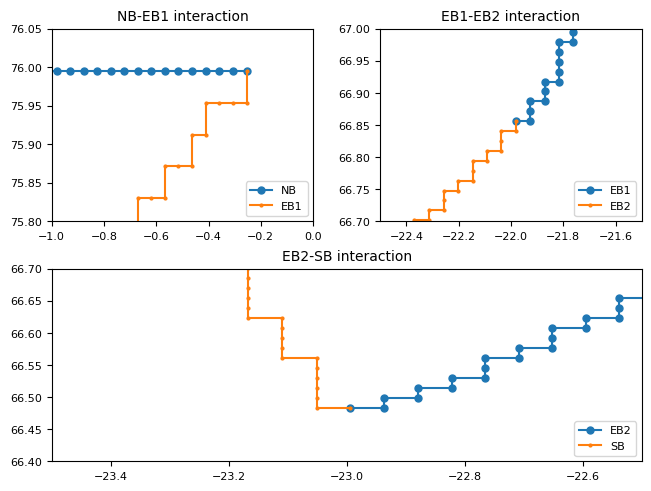

In [134]:
# Test for boundary overlap
fig, axs = plt.subplot_mosaic([[0,1],[2,2]],layout='constrained')

axs[0].set_title('NB-EB1 interaction')
axs[0].plot(XC_north,YC_north,marker='o', markersize=5,label='NB')
axs[0].plot(XC_east1,YC_east1,marker='o',markersize=2,label='EB1')
axs[0].set_xlim(-1,0)
axs[0].set_ylim(75.8,76.05)
axs[0].legend(loc='lower right')


axs[1].set_title('EB1-EB2 interaction')
axs[1].plot(XC_east1,YC_east1,marker='o', markersize=5,label='EB1')
axs[1].plot(XC_east2,YC_east2,marker='o', markersize=2,label='EB2')
axs[1].set_xlim(-22.5,-21.5)
axs[1].set_ylim(66.7,67)
axs[1].legend(loc='lower right')

axs[2].set_title('EB2-SB interaction')
axs[2].plot(XC_east2,YC_east2,marker='o', markersize=5,label='EB2')
axs[2].plot(XC_south,YC_south,marker='o', markersize=2,label='SB')
axs[2].set_xlim(-23.5,-22.5)
axs[2].set_ylim(66.4,66.7)
axs[2].legend(loc='lower right')

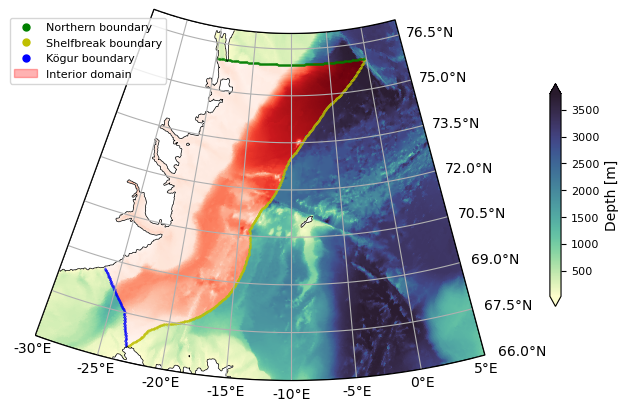

In [92]:
# Plot map and mooring locations
fig, ax = plt.subplots(figsize=(6.2217, 4), subplot_kw={'projection': ccrs.NorthPolarStereo(central_longitude=-10)}, layout='constrained') # 

extent = [-30+10, 5+10, 66, 77]

mesh = ax.pcolormesh(depth.X, depth.Y, depth, cmap=cmo.deep, transform=ccrs.PlateCarree())
cbar = fig.colorbar(mesh, shrink=0.6, pad=0.005, extend='both')
cbar.set_label('Depth [m]')

XC = [mooring_shelfExtended_kogur["XC"][x].values[0][0] for x in mooring_shelfExtended_kogur['mooring']]
YC = [mooring_shelfExtended_kogur["YC"][x].values[0][0] for x in mooring_shelfExtended_kogur['mooring']]
ax.plot(XC, YC, "y.", markersize=0.5, transform=ccrs.PlateCarree())

XC = [mooring_shelfExtended["XC"][x-pos_Extended[-1]].values[0][0] for x in mooring_shelfExtended['mooring']]
YC = [mooring_shelfExtended["YC"][x-pos_Extended[-1]].values[0][0] for x in mooring_shelfExtended['mooring']]
ax.plot(XC, YC, "y.", markersize=0.5, transform=ccrs.PlateCarree(), label='ShelfExtended transect')

XC = [mooring_kogur["XC"][x].values[0][0] for x in mooring_kogur['mooring']]
YC = [mooring_kogur["YC"][x].values[0][0] for x in mooring_kogur['mooring']]
ax.plot(XC, YC, "b.", markersize=0.5, transform=ccrs.PlateCarree(), label='Kögur transect')

XC = [mooring_north["XC"][x-23].values[0][0] for x in mooring_north['mooring']]
YC = [mooring_north["YC"][x-23].values[0][0] for x in mooring_north['mooring']]
ax.plot(XC, YC, "g.", markersize=0.5, transform=ccrs.PlateCarree(), label='Northern transect')

ax.contour(depth_no_nan.XC, depth_no_nan.YC, depth_no_nan, [0], linewidths=0.5, colors='black', transform=ccrs.PlateCarree())

ax.pcolormesh(masked_data.XC,masked_data.YC,masked_data,transform=ccrs.PlateCarree(),cmap='Reds')

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=ax.transData, edgecolor='black', facecolor='none')
ax.add_patch(patch)

# Set the boundary using the transformed path
ax.set_boundary(patch.get_path(), transform=ax.transData)

# Add gridlines without labels
gl = ax.gridlines(draw_labels=False)

# Manually add the labels for the bottom and right sides
xticks = np.arange(extent[0]-10, extent[1]-10 + 1, 5)  # Adjust the range and step as needed
yticks = np.arange(extent[2], extent[3] + 1, 1.5)  # Adjust the range and step as needed

# Add bottom labels
for xtick in xticks:
    ax.text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=10, ha='center', va='top')

# Add right labels
for ytick in yticks:
    ax.text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=10, ha='left', va='center')

marker_legend1 = Line2D([], [], color='g', marker='.', linestyle='None', markersize=10, label='Northern boundary')
marker_legend2 = Line2D([], [], color='y', marker='.', linestyle='None', markersize=10, label='Shelfbreak boundary')
marker_legend3 = Line2D([], [], color='b', marker='.', linestyle='None', markersize=10, label='Kögur boundary')
rectangle_legend = mpatches.Patch(color='red', alpha=0.3, label='Interior domain')

# Create custom legend
ax.legend(handles=[marker_legend1,marker_legend2,marker_legend3, rectangle_legend],loc=[-0.05,0.8])

fig.savefig(r'/nird/home/ekv036/MSc/Fig/Structure',dpi=300, facecolor='w', edgecolor='w',
          orientation='landscape', format=None,
          transparent=False, bbox_inches=None,pad_inches=0.25)

In [93]:
display(FW_input)

<xarray.DataArray 'oceFWflx' (time: 1460, Y: 539, X: 744)>
[585483360 values with dtype=float64]
Coordinates:
  * X        (X) float64 -29.92 -29.84 -29.76 -29.67 ... 9.683 9.77 9.858 9.946
  * Y        (Y) float64 66.01 66.02 66.04 66.05 ... 76.82 76.87 76.92 76.97
    XC       (Y, X) float64 ...
    YC       (Y, X) float64 ...
  * time     (time) datetime64[ns] 2017-09-01 ... 2018-08-31T18:00:00
Attributes:
    description:    net surface Fresh-Water flux into the ocean (+=down), >0 ...
    units:          kg/m^2/s
    standard_name:  oceFWflx
    long_name:      net surface Fresh-Water flux into the ocean (+=down), >0 ...

In [94]:
# Convert the FW flux of the interior to mSv

FW_input = FW_input.where(~mask).where(cond_bound)*area/1000 * 1/1000 # One m^3 is 1000L == 1000kg, thus to convert it into mSv we divide by 1/1000000
FW_input_mean = FW_input.mean(dim='time')



In [95]:
# Define S_ref based on earlier computation (See Reference_salinity.ipynb)
from FW import FWT
ref_salinity = 34.81
rewriteFWT = False # Defined to save time if previously run

In [96]:
if rewriteFWT:
    kogur_r = FWT(mooringDataset=mooring_kogur,ref_salinity=ref_salinity)
else:
    kogur_r_ds = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/kogur_transport.nc')
    

In [97]:
if rewriteFWT:
    shelfExtended_r = FWT(mooringDataset=mooring_shelfExtended,ref_salinity=ref_salinity)
else:
    shelfExtended_r_ds = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/shelfExtended_transport_short.nc')
    

In [98]:
if rewriteFWT:
    shelfExtendedKogur_r = FWT(mooringDataset=mooring_shelfExtended_kogur,ref_salinity=ref_salinity)
else:
    shelfExtendedKogur_r_ds = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/shelfExtendedKogur_transport.nc')


In [99]:
display(mooring_north)

<xarray.Dataset>
Dimensions:            (time: 1460, Z: 216, mooring: 428, Y: 1, Xp1: 2, X: 1,
                        Yp1: 2, path: 2, Zp1: 217, Zu: 216, Zl: 216,
                        time_midp: 1459, mooring_midp: 491)
Coordinates: (12/29)
  * Z                  (Z) float64 -1.0 -3.5 -7.0 ... -3.922e+03 -3.942e+03
  * Zp1                (Zp1) float64 0.0 -2.0 -5.0 ... -3.932e+03 -3.951e+03
  * Zu                 (Zu) float64 -2.0 -5.0 -9.0 ... -3.932e+03 -3.951e+03
  * Zl                 (Zl) float64 0.0 -2.0 -5.0 ... -3.913e+03 -3.932e+03
    drF                (Z) float64 ...
    XC                 (mooring, Y, X) float64 -19.82 -19.77 ... -0.3069 -0.2545
    ...                 ...
  * Y                  (Y) int64 0
  * Xp1                (Xp1) int64 0 1
  * Yp1                (Yp1) int64 0 1
    mooring_dist       (mooring) float64 32.1 33.46 34.83 ... 555.7 557.1 558.5
  * mooring_midp       (mooring_midp) float64 0.5 1.5 2.5 ... 488.5 489.5 490.5
    mooring_midp_dist  (mooring_midp) float64 ...
Dimensions without coordinates: path
Data variables: (12/15)
    U                  (time, Z, mooring, Y, Xp1, X) float64 nan ... nan
    V                  (time, Z, mooring, Yp1, X, Y) float64 -0.01639 ... nan
    Temp               (time, Z, mooring, Y, X) float64 -0.7083 -1.63 ... nan
    S                  (time, Z, mooring, Y, X) float64 30.35 30.26 ... nan nan
    transport          (time, Z, mooring, path, Y, X) float64 0.0 ... 0.0
    Vtransport         (time, Z, mooring, path, Y, X) float64 0.0 ... 0.0
    ...                 ...
    Y_Utransport       (mooring, path, Y, X) float64 nan nan nan ... nan nan nan
    X_Utransport       (mooring, path, Y, X) float64 nan nan nan ... nan nan nan
    Y_Vtransport       (mooring, path, Y, X) float64 76.02 75.97 ... 76.02 75.97
    X_Vtransport       (mooring, path, Y, X) float64 -19.82 -19.82 ... -0.2545
    dir_Utransport     (mooring, path, Y, X) float64 nan nan nan ... nan nan nan
    dir_Vtransport     (mooring, path, Y, X) float64 1.0 1.0 1.0 ... 1.0 1.0 1.0
Attributes: (12/24)
    MITgcm_version:          checkpoint67l
    build_user:              malmans2@jhu.edu
    build_host:              compute0673
    build_date:              Fri Nov  8 01:36:45 EST 2019
    MITgcm_URL:              http://mitgcm.org
    MITgcm_tag_id:           
    ...                      ...
    OceanSpy_parameters:     {'rSphere': 6371.0, 'eq_state': 'mdjwf', 'rho0':...
    OceanSpy_name:           IGPyearlong
    OceanSpy_description:    High-resolution numerical simulation carried out...
    OceanSpy_projection:     Mercator(**{})
    OceanSpy_grid_coords:    {'Y': {'Y': None, 'Yp1': 0.5}, 'X': {'X': None, ...
    OceanSpy_grid_periodic:  []

In [100]:
mooring_north = mooring_north.drop_vars(names=['transport','Vtransport','Utransport','Y_transport','X_transport','Y_Utransport','X_Utransport','Y_Vtransport','X_Vtransport','dir_Utransport','dir_Vtransport'])
if rewriteFWT:
    north_r = FWT(mooringDataset=mooring_north,ref_salinity=ref_salinity)
else:
    north_r_ds = xr.open_dataset(r'/nird/projects/NS9608K/MSc_EK/Data/north_transport_short.nc')


In [101]:
# Import or create files of the advective FWT
file_paths = [ # List of file paths
    r'/nird/projects/NS9608K/MSc_EK/Data/kogur_transport.nc',
    r'/nird/projects/NS9608K/MSc_EK/Data/north_transport_short.nc',
    r'/nird/projects/NS9608K/MSc_EK/Data/shelfExtended_transport_short.nc',
    r'/nird/projects/NS9608K/MSc_EK/Data/shelfExtendedKogur_transport.nc'
]

try:
    kogur_r = kogur_r_ds['kogur']
    north_r = north_r_ds['north']
    shelfExtended_r = shelfExtended_r_ds['shelfExtended']
    shelfExtendedKogur_r = shelfExtendedKogur_r_ds['shelfExtendedKogur']
except:
    # Create individual datasets
    kogur_ds = xr.Dataset({'kogur': kogur_r})
    north_ds = xr.Dataset({'north': north_r})
    shelfExtended_ds = xr.Dataset({'shelfExtended': shelfExtended_r})
    shelfExtendedKogur_ds = xr.Dataset({'shelfExtendedKogur': shelfExtendedKogur_r})

    # List of datasets
    datasets = [kogur_ds, north_ds, shelfExtended_ds, shelfExtendedKogur_ds]

    # Save multiple datasets to multiple files
    xr.save_mfdataset(datasets, file_paths)

    
# Compute the mean FWT in space for all boundaries
kogur = kogur_r.mean(dim='path').sel(Y=0).sel(X=0)
kogur = kogur.sum(dim='Z')*1000
kogur = kogur.mean(dim='time')
north = north_r.mean(dim='path').sel(Y=0).sel(X=0)
north = north.sum(dim='Z')*1000
north = north.mean(dim='time')
shelfExtended = shelfExtended_r.mean(dim='path').sel(Y=0).sel(X=0)
shelfExtended = shelfExtended.sum(dim='Z')*1000
shelfExtended = shelfExtended.mean(dim='time')
shelfExtendedKogur = shelfExtendedKogur_r.mean(dim='path').sel(Y=0).sel(X=0)
shelfExtendedKogur = shelfExtendedKogur.sum(dim='Z')*1000
shelfExtendedKogur = shelfExtendedKogur.mean(dim='time')

array(8.90288188)

array(0.13520651)

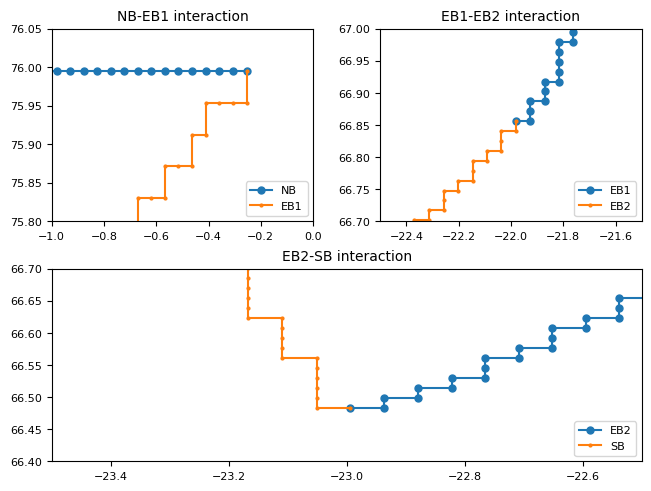

In [ ]:
# Test for boundary overlap after computed FWT (Found that they overlap, but the function does not compute the first or latest point in the array, thus these points equal zero)
test = kogur_r.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z')*1000
display(test.max(dim='time')[1].values,test.max(dim='time')[-2].values)

XC_north = north.XC
YC_north = north.YC

XC_east1 = shelfExtended.XC
YC_east1 = shelfExtended.YC

XC_east2 = shelfExtendedKogur.XC
YC_east2 = shelfExtendedKogur.YC

XC_south = kogur.XC
YC_south = kogur.YC

fig, axs = plt.subplot_mosaic([[0,1],[2,2]],layout='constrained')

axs[0].set_title('NB-EB1 interaction')
axs[0].plot(XC_north,YC_north,marker='o', markersize=5,label='NB')
axs[0].plot(XC_east1,YC_east1,marker='o',markersize=2,label='EB1')
axs[0].set_xlim(-1,0)
axs[0].set_ylim(75.8,76.05)
axs[0].legend(loc='lower right')


axs[1].set_title('EB1-EB2 interaction')
axs[1].plot(XC_east1,YC_east1,marker='o', markersize=5,label='EB1')
axs[1].plot(XC_east2,YC_east2,marker='o', markersize=2,label='EB2')
axs[1].set_xlim(-22.5,-21.5)
axs[1].set_ylim(66.7,67)
axs[1].legend(loc='lower right')

axs[2].set_title('EB2-SB interaction')
axs[2].plot(XC_east2,YC_east2,marker='o', markersize=5,label='EB2')
axs[2].plot(XC_south,YC_south,marker='o', markersize=2,label='SB')
axs[2].set_xlim(-23.5,-22.5)
axs[2].set_ylim(66.4,66.7)
axs[2].legend(loc='lower right')

In [102]:
# Computes masked import and export part of each boundary and interior domain

kogur_h_p = kogur_r.where(kogur_r>=0)
kogur_h_p = kogur_h_p.mean(dim='path').sel(Y=0).sel(X=0)
kogur_h_p = kogur_h_p.sum(dim='Z')*1000
kogur_h_p = kogur_h_p.mean(dim='time')

kogur_h_n = kogur_r.where(kogur_r<=0)
kogur_h_n = kogur_h_n.mean(dim='path').sel(Y=0).sel(X=0)
kogur_h_n = kogur_h_n.sum(dim='Z')*1000
kogur_h_n = kogur_h_n.mean(dim='time')


cond1 = (north_r>=0) & ((north_r.XC <= 3.788806))
cond2 = (north_r<=0) & ((north_r.XC <= 3.788806))

north_h_p = north_r.where(cond1)
north_h_p = north_h_p.mean(dim='path').sel(Y=0).sel(X=0)
north_h_p = north_h_p.sum(dim='Z')*1000
north_h_p = north_h_p.mean(dim='time')

north_h_n = north_r.where(cond2)
north_h_n = north_h_n.mean(dim='path').sel(Y=0).sel(X=0)
north_h_n = north_h_n.sum(dim='Z')*1000
north_h_n = north_h_n.mean(dim='time')


cond1 = (shelfExtended_r>=0)# & ((shelfExtended_.YC < 74) & (shelfExtended_.YC > 70))
cond2 = (shelfExtended_r<=0)# & ((shelfExtended_.YC < 74) & (shelfExtended_.YC > 70))

shelfExtended_h_p = shelfExtended_r.where(cond1)
shelfExtended_h_p = shelfExtended_h_p.mean(dim='path').sel(Y=0).sel(X=0)
shelfExtended_h_p = shelfExtended_h_p.sum(dim='Z')*1000
shelfExtended_h_p = shelfExtended_h_p.mean(dim='time')

shelfExtended_h_n = shelfExtended_r.where(cond2)
shelfExtended_h_n = shelfExtended_h_n.mean(dim='path').sel(Y=0).sel(X=0)
shelfExtended_h_n = shelfExtended_h_n.sum(dim='Z')*1000
shelfExtended_h_n = shelfExtended_h_n.mean(dim='time')


shelfExtendedKogur_h_p = shelfExtendedKogur_r.where(shelfExtendedKogur_r>=0)
shelfExtendedKogur_h_p = shelfExtendedKogur_h_p.mean(dim='path').sel(Y=0).sel(X=0)
shelfExtendedKogur_h_p = shelfExtendedKogur_h_p.sum(dim='Z')*1000
shelfExtendedKogur_h_p = shelfExtendedKogur_h_p.mean(dim='time')

shelfExtendedKogur_h_n = shelfExtendedKogur_r.where(shelfExtendedKogur_r<=0)
shelfExtendedKogur_h_n = shelfExtendedKogur_h_n.mean(dim='path').sel(Y=0).sel(X=0)
shelfExtendedKogur_h_n = shelfExtendedKogur_h_n.sum(dim='Z')*1000
shelfExtendedKogur_h_n = shelfExtendedKogur_h_n.mean(dim='time')


FW_in_p = FW_input.where(FW_input>=0)
FW_in_p = FW_in_p.sum(dim='X').sum(dim='Y').mean(dim='time')

FW_in_n = FW_input.where(FW_input<=0)
FW_in_n = FW_in_n.sum(dim='X').sum(dim='Y').mean(dim='time')



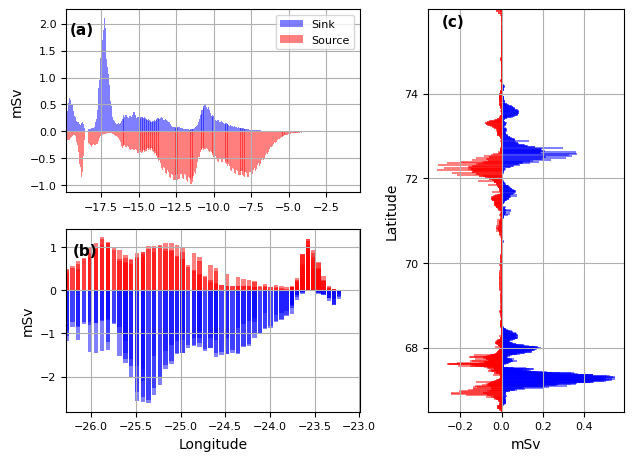

In [103]:
plt.rcParams.update({
    'font.size': 11,       # Default text size
    'axes.titlesize': 10,  # Title size
    'axes.labelsize': 10,  # Axis label size
    'xtick.labelsize': 8, # X-tick label size
    'ytick.labelsize': 8, # Y-tick label size
    'legend.fontsize': 8, # Legend font size
    'figure.titlesize': 12 # Figure title size
})

fig, axd = plt.subplot_mosaic([['ul','r'],
                               ['ll','r']],
                               gridspec_kw={'width_ratios': [0.6, 0.4]},
                               figsize=(6.2217, 4.5), layout='constrained')

# axd['ul'].plot(north.XC,north,color='g',alpha=0.5,label='FWT')
# axd['ul'].set_title(f'a) Northern NET FWT: {np.round(north.sum(dim="mooring").values,2)} mSv',fontweight='bold')
axd['ul'].grid()
axd['ul'].bar(north.XC, north_h_p, width=0.05, color='blue', alpha=0.5,label=f'Sink') # : {np.round(north_h_p.sum().values,2)}
axd['ul'].bar(north.XC, north_h_n, width=0.05, color='red', alpha=0.5,label=f'Source') # : {np.round(north_h_n.sum().values,2)}
axd['ul'].set_xlim(north.XC[0],north.XC[-1])
axd['ul'].set_ylabel('mSv')
axd['ul'].legend(loc='upper right')
axd['ul'].annotate(text='(a)',xy=[north.XC[5],1.8],fontweight='bold')

# axd['ll'].plot(kogur.XC,kogur,color='g',alpha=0.5,label='FWT')
# axd['ll'].set_title(f'b) Kögur NET FWT: {np.round(kogur.sum(dim="mooring").values,2)} mSv',fontweight='bold')
axd['ll'].grid()
axd['ll'].bar(kogur.XC, kogur_h_p, width=0.05, color='red', alpha=0.5,label=f'Northward: {np.round(kogur_h_p.sum().values,2)}')
axd['ll'].bar(kogur.XC, kogur_h_n, width=0.05, color='blue', alpha=0.5,label=f'Southhward: {np.round(kogur_h_n.sum().values,2)}')
axd['ll'].set_xlim(kogur.XC[0],kogur.XC[-1])
axd['ll'].set_xlabel('Longitude')
axd['ll'].set_ylabel('mSv')
# axd['ll'].legend()
axd['ll'].annotate(text='(b)',xy=[kogur.XC[4],0.8],fontweight='bold')

# axd['r'].plot(shelfExtended, shelfExtended.YC,color='g',alpha=0.5,label='FWT')
# axd['r'].set_title(f'c) Shelfbreak NET FWT: {np.round(shelfExtended.sum(dim="mooring").values + shelfExtendedKogur.sum(dim="mooring").values,2)} mSv',fontweight='bold')
axd['r'].barh(shelfExtended.YC, shelfExtended_h_p, height=0.05, color='blue', alpha=0.5, label=f'Eastward: {np.round(shelfExtended_h_p.sum().values+shelfExtendedKogur_h_p.sum().values,2)}')
axd['r'].barh(shelfExtended.YC, shelfExtended_h_n, height=0.05, color='red', alpha=0.5, label=f'Westward: {np.round(shelfExtended_h_n.sum().values+shelfExtendedKogur_h_n.sum().values,2)}')

# axd['r'].plot(shelfExtendedKogur, shelfExtendedKogur.YC,color='g',alpha=0.5)
axd['r'].barh(shelfExtendedKogur.YC, shelfExtendedKogur_h_p, height=0.05, color='blue', alpha=0.5)
axd['r'].barh(shelfExtendedKogur.YC, shelfExtendedKogur_h_n, height=0.05, color='red', alpha=0.5)
axd['r'].set_ylim(shelfExtendedKogur.YC[-1],shelfExtended.YC[0])
axd['r'].set_ylabel('Latitude')
axd['r'].set_xlabel('mSv')
axd['r'].grid()
# axd['r'].legend()
axd['r'].annotate(text='(c)',xy=[-0.29,75.6],fontweight='bold')



fig.savefig(r'/nird/home/ekv036/MSc/Fig/FW_Budget_boundary',dpi=300, facecolor='w', edgecolor='w',
          orientation='landscape', format=None,
          transparent=False, bbox_inches='tight',pad_inches=0.25)

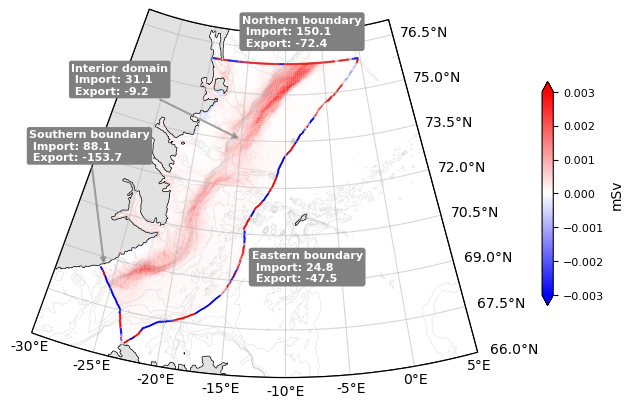

In [ ]:
# Function to create a LineCollection
def create_line_collection_with_edgecolor(XC, YC, FWT_N, cmap,vmin,vmax, linewidth=1.5, edgecolor='black', edgewidth=1, edge_alpha=0.5):
    # Create line segments
    points = np.array([XC, YC]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create the edge line collection
    edge_lc = LineCollection(segments, colors=[edgecolor], linewidths=edgewidth, alpha=edge_alpha, transform=ccrs.PlateCarree())

    # Create the main line collection
    main_lc = LineCollection(segments, cmap=cmap,norm=plt.Normalize(vmin=vmin, vmax=vmax), transform=ccrs.PlateCarree())
    main_lc.set_array(np.array(FWT_N))
    main_lc.set_linewidth(linewidth)
    
    return edge_lc, main_lc


vmin = -0.003
vmax = 0.003
# norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

# Create a figure and axis with Cartopy using NorthPolarStereo projection
fig, ax = plt.subplots(figsize=(6.2217, 4), subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)), layout='constrained')

# Set the extent to focus on the desired geographical area
extent = [-30+10, 5+10, 66, 77]

# Example data for testing
lon = depth['XC']
lat = depth['YC']
cmap = plt.get_cmap('bwr')
mesh = ax.pcolormesh(FW_input_mean.X, FW_input_mean.Y, FW_input_mean, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
cbar = fig.colorbar(mesh, shrink=0.6, pad=0.005, extend='both')
cbar.set_label('mSv')

land = depth_no_nan.where(depth_no_nan==0)

ax.pcolormesh(land.X,land.Y,land,cmap='Greys',vmin=-25,vmax=100, transform=ccrs.PlateCarree())

# Add land contour
ax.contour(lon, lat, depth_no_nan, [0], colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
ax.contour(lon, lat, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey', linewidths=0.5,alpha=0.2, transform=ccrs.PlateCarree())

# Add the first FWT array
XC = [shelfExtendedKogur["XC"][x].values for x in shelfExtendedKogur['mooring']]
YC = [shelfExtendedKogur["YC"][x].values for x in shelfExtendedKogur['mooring']]
FWT_SEK = [-shelfExtendedKogur[x].values for x in shelfExtendedKogur['mooring']]
edge_lc, main_lc = create_line_collection_with_edgecolor(XC, YC, FWT_SEK, cmap=cmap,vmin=vmin,vmax=vmax)
ax.add_collection(edge_lc)
ax.add_collection(main_lc)

# Add the second FWT array
XC = [shelfExtended["XC"][x-pos_Extended[-1]].values for x in shelfExtended['mooring']]
YC = [shelfExtended["YC"][x-pos_Extended[-1]].values for x in shelfExtended['mooring']]
FWT_SE = [-shelfExtended[x-pos_Extended[-1]].values for x in shelfExtended['mooring']]
edge_lc, main_lc = create_line_collection_with_edgecolor(XC, YC, FWT_SE, cmap=cmap,vmin=vmin,vmax=vmax)
ax.add_collection(edge_lc)
ax.add_collection(main_lc)

# Add the third FWT array as scatter plot
XC = [kogur["XC"][x].values for x in kogur['mooring']]
YC = [kogur["YC"][x].values for x in kogur['mooring']]
FWT_K = [kogur[x].values for x in kogur['mooring']]
# ax.scatter(XC, YC, c=FWT_K, cmap=cmap,norm=norm, alpha=0.7, transform=ccrs.PlateCarree())
edge_lc, main_lc = create_line_collection_with_edgecolor(XC, YC, FWT_K, cmap=cmap,vmin=vmin,vmax=vmax)
ax.add_collection(edge_lc)
ax.add_collection(main_lc)

# Add the fourth FWT array as scatter plot
XC = [north["XC"][x-23].values for x in north['mooring']]
YC = [north["YC"][x-23].values for x in north['mooring']]
FWT_N = [-north[x-23].values for x in north['mooring']]
# ax.scatter(XC, YC, c=FWT_N, cmap=cmap,norm=norm, alpha=0.7, transform=ccrs.PlateCarree())
edge_lc, main_lc = create_line_collection_with_edgecolor(XC, YC, FWT_N, cmap=cmap,vmin=vmin,vmax=vmax)
ax.add_collection(edge_lc)
ax.add_collection(main_lc)


# Text

texts = [
    (f'Northern boundary\n Import: {np.round(-north_h_n.sum().values,1)}\n Export: {np.round(-north_h_p.sum().values,1)}', -16, 76.5),
    (f'Eastern boundary\n Import: {np.round(-shelfExtended_h_n.sum().values + -shelfExtendedKogur_h_n.sum().values,1)}\n Export: {np.round(-shelfExtended_h_p.sum().values + -shelfExtendedKogur_h_p.sum().values,1)}', -13, 69)
    #(f'Net land runoff and precipitation \n Import: {np.round(FW_input2_mean.sum().values,4)}',-35,74.5)
]

for text, x, y in texts:
    ax.text(x, y, text, transform=ccrs.PlateCarree(),
            fontsize=8, weight='bold', color='white',
            bbox=dict(facecolor='grey', alpha=1, edgecolor='none', boxstyle='round,pad=0.25'))

text_location = (-36, 71)
arrow_location = (-26, 68.7)

(f'', )
# Add the annotation with an arrow
ax.annotate(f'Southern boundary\n Import: {np.round(kogur_h_p.sum().values,1)}\n Export: {np.round(kogur_h_n.sum().values,1)}', 
            xy=arrow_location, 
            xytext=text_location, 
            fontsize=8, 
            weight='bold', 
            color='white',
            bbox=dict(facecolor='grey', edgecolor='none', boxstyle='round,pad=0.2'),
            arrowprops=dict(facecolor='grey', edgecolor='grey', arrowstyle='->', lw=1.5,alpha=0.7),
            transform=ccrs.PlateCarree())

text_location = (-35, 73.5)
arrow_location = (-15, 73.5)

# Add the annotation with an arrow
ax.annotate(f'Interior domain\n Import: {np.round(FW_in_p.values,1)} \n Export: {np.round(FW_in_n.values,1)}', 
            xy=arrow_location, 
            xytext=text_location, 
            fontsize=8, 
            weight='bold', 
            color='white',
            bbox=dict(facecolor='grey', edgecolor='none', boxstyle='round,pad=0.2'),
            arrowprops=dict(facecolor='grey', edgecolor='grey', arrowstyle='->', lw=1.5,alpha=0.7),
            transform=ccrs.PlateCarree())

# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=ax.transData, edgecolor='black', facecolor='none')
ax.add_patch(patch)

# Set the boundary using the transformed path
ax.set_boundary(patch.get_path(), transform=ax.transData)

# Add gridlines without labels
gl = ax.gridlines(draw_labels=False,alpha=0.5)

# Manually add the labels for the bottom and right sides
xticks = np.arange(extent[0]-10, extent[1]-10 + 1, 5)  # Adjust the range and step as needed
yticks = np.arange(extent[2], extent[3] + 1, 1.5)  # Adjust the range and step as needed

# Add bottom labels
for xtick in xticks:
    ax.text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=10, ha='center', va='top')

# Add right labels
for ytick in yticks:
    ax.text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=10, ha='left', va='center')


# Save the figure
fig.savefig(r'/nird/home/ekv036/MSc/Fig/ModelFWTMap',dpi=300, facecolor='w', edgecolor='w',
          orientation='landscape', format=None,
          transparent=False, bbox_inches=None,pad_inches=0.25)

In [105]:
import pandas as pd

def resample_and_shift(data):
    resampled_data = data.resample(time='M').mean(dim='time').mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring')
    # Calculate the midpoint of the current month
    new_time = []
    for date in resampled_data['time'].values:
        date = pd.Timestamp(date)
        start_of_month = date.replace(day=1)
        end_of_month = (start_of_month + pd.DateOffset(months=1)) - pd.Timedelta(days=1)
        midpoint_of_month = start_of_month + (end_of_month - start_of_month) / 2
        new_time.append(midpoint_of_month)
    resampled_data['time'] = pd.to_datetime(new_time)
    return resampled_data

def resample_and_shift_normal_data(data):
    resampled_data = data.resample(time='M').mean(dim='time').sum(dim='X').sum(dim='Y')
    # Calculate the midpoint of the current month
    new_time = []
    for date in resampled_data['time'].values:
        date = pd.Timestamp(date)
        start_of_month = date.replace(day=1)
        end_of_month = (start_of_month + pd.DateOffset(months=1)) - pd.Timedelta(days=1)
        midpoint_of_month = start_of_month + (end_of_month - start_of_month) / 2
        new_time.append(midpoint_of_month)
    resampled_data['time'] = pd.to_datetime(new_time)
    return resampled_data

# Apply the function to each dataset
kogur_m = resample_and_shift(kogur_r)
north_m = resample_and_shift(north_r)
shelfExtended_m = resample_and_shift(shelfExtended_r)
shelfExtendedKogur_m = resample_and_shift(shelfExtendedKogur_r)

kogur_d = kogur_r.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring')
north_d = north_r.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring')
shelfExtended_d = shelfExtended_r.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring')
shelfExtendedKogur_d = shelfExtendedKogur_r.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring')
FW_input_d = FW_input.resample(time='D').mean(dim='time').sum(dim='X').sum(dim='Y')
FW_input_m = resample_and_shift_normal_data(FW_input)
shelfbreak_d = shelfExtended_d + shelfExtendedKogur_d
shelfbreak_m = shelfExtended_m + shelfExtendedKogur_m

def err_resample(dataset_d):
    resampled_data = dataset_d.resample(time='M').std()
    new_time = []
    for date in resampled_data['time'].values:
        date = pd.Timestamp(date)
        start_of_month = date.replace(day=1)
        end_of_month = (start_of_month + pd.DateOffset(months=1)) - pd.Timedelta(days=1)
        midpoint_of_month = start_of_month + (end_of_month - start_of_month) / 2
        new_time.append(midpoint_of_month)
    resampled_data['time'] = pd.to_datetime(new_time)
    return resampled_data

err_kogur = err_resample(kogur_d*1000)
err_north = err_resample(north_d*1000)
err_shelfbreak = err_resample(shelfbreak_d*1000)
err_FW_input = err_resample(FW_input_d)


/nird/home/ekv036/MSc_env/lib/python3.11/site-packages/xarray/core/groupby.py:508: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/nird/home/ekv036/MSc_env/lib/python3.11/site-packages/xarray/core/groupby.py:508: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/nird/home/ekv036/MSc_env/lib/python3.11/site-packages/xarray/core/groupby.py:508: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/nird/home/ekv036/MSc_env/lib/python3.11/site-packages/xarray/core/groupby.py:508: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(
/nird/home/ekv036/MSc_env/lib/python3.11/site-packages/xarray/core/groupby.py:508: FutureWarning: 'M' is deprecated and will be removed in a future vers

In [106]:
display(kogur_d*1000)

<xarray.DataArray 'kogur' (time: 365)>
array([-7.01594667e+01, -9.12391249e+01, -1.20648250e+02, -1.65814160e+02,
       -1.92991680e+02, -1.46085840e+02, -1.18282594e+02, -1.02508331e+02,
       -1.12277156e+02, -1.18982383e+02, -1.26725096e+02, -1.25533210e+02,
       -1.18777690e+02, -1.12848344e+02, -8.64684540e+01, -3.79084783e+01,
       -4.04726232e+01, -5.74107018e+01, -8.92723436e+01, -1.25613086e+02,
       -1.35884215e+02, -1.22277616e+02, -1.09210427e+02, -1.31319120e+02,
       -1.13802803e+02, -9.19519010e+01, -1.20889882e+02, -9.43967180e+01,
       -9.15554690e+01, -1.05884856e+02, -9.56836667e+01, -1.05923365e+02,
       -9.55144569e+01, -8.57092292e+01, -1.14505039e+02, -9.86913520e+01,
       -8.88904595e+01, -8.18309424e+01, -9.21774302e+01, -1.45929458e+02,
       -1.85761677e+02, -2.06337684e+02, -2.18971537e+02, -2.34122008e+02,
       -1.62647793e+02, -1.32173385e+02, -1.16105955e+02, -1.01429377e+02,
       -1.15525334e+02, -1.20334997e+02, -1.04488445e+02, -8.19725865e+01,
       -1.20331098e+02, -1.37443125e+02, -9.81348387e+01, -1.01050599e+02,
       -1.36798150e+02, -1.73808843e+02, -1.36507964e+02, -1.36182983e+02,
       -1.29348098e+02, -8.44321226e+01, -6.04129577e+01, -1.14990595e+02,
       -1.55314622e+02, -1.51422357e+02, -1.82493731e+02, -1.46906198e+02,
       -1.18049983e+02, -1.02328114e+02, -9.16610806e+01, -1.38904393e+02,
       -9.39152003e+01, -9.96234140e+01, -9.57104107e+01, -8.41899331e+01,
       -1.08866062e+02, -1.04738291e+02, -8.03243838e+01, -9.25982030e+01,
...
       -1.83477699e+01, -2.96679684e+01, -3.19471593e+01, -2.92659886e+01,
       -1.76524024e+01,  1.28286206e+00, -6.01996246e-01, -2.26643775e+00,
       -1.54801174e+01, -1.11760613e+01, -8.84840444e+00, -1.33314497e+01,
       -1.64244782e+01, -1.44070213e+01, -1.23460493e+01, -1.03606973e+01,
       -1.14488506e+01, -1.82730740e+01, -9.51101702e+00, -2.47102613e+01,
       -6.79605667e+00, -1.48060367e+01,  1.25182358e+01,  3.37328774e+01,
        3.74119447e+01,  1.17159488e+01,  8.14803538e+00, -5.18130415e+00,
       -1.88704002e+01, -2.27324583e+01, -2.55052251e+01, -1.63479122e+01,
       -2.16014494e+01, -2.13744245e+01, -2.27011763e+01, -2.70155288e+01,
       -3.39433755e+01, -2.26179151e+01, -2.34191495e+01, -1.81709893e+01,
       -2.00329413e+01, -2.23635942e+01, -2.63206912e+01, -5.62038010e+01,
       -5.75875064e+01, -4.14343665e+01, -3.33343777e+01, -2.93687264e+01,
       -1.85027630e+01, -1.64819877e+01, -1.86471529e+01, -1.87522117e+01,
       -2.82332127e+01, -2.04880630e+01, -1.54225849e+01, -9.34482907e+00,
       -9.01020918e+00, -9.72394817e+00, -1.13787255e-01, -1.36499830e+01,
       -1.91055645e+01, -2.21478588e+01, -1.55849330e+01, -2.27262912e+01,
       -1.87229688e+01, -7.30033071e+00, -1.39168533e+01, -2.08028992e+01,
       -1.82510148e+01, -1.82638722e+01, -2.09256150e+01, -2.16080990e+01,
       -7.48035317e+00, -2.34136623e+01, -2.08528769e+01, -1.87125665e+01,
       -1.49165243e+01])
Coordinates:
  * time     (time) datetime64[ns] 2017-09-01 2017-09-02 ... 2018-08-31
    Y        int64 0
    X        int64 0

In [107]:
Bud_tot_d = kogur_d*1000 - north_d*1000 - shelfbreak_d*1000 + FW_input_d #+FW_input2_d# + FW_input_d
Bud_tot_m = kogur_m*1000 - north_m*1000 - shelfbreak_m*1000 + FW_input_m #+FW_input2_m# + FW_input_m
err_Bud = err_resample(Bud_tot_d)
mean_Bud = Bud_tot_d.mean()
bud_std = Bud_tot_d.std()
print('Bud: ',Bud_tot_d.mean().values,'Std_bud: ',bud_std.values)

Bud:  11.071175017775014 Std_bud:  40.54524484298218


/nird/home/ekv036/MSc_env/lib/python3.11/site-packages/xarray/core/groupby.py:508: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  index_grouper = pd.Grouper(


In [108]:
display(err_north)
display(north_m*1000)

<xarray.DataArray 'north' (time: 12)>
array([23.24690022, 22.19577803, 29.1783883 , 30.74193015, 36.78267158,
       41.07080943, 17.89744116,  6.57829767, 10.00463103, 11.11667742,
       12.44208307, 10.73450749])
Coordinates:
    Y        int64 0
    X        int64 0
  * time     (time) datetime64[ns] 2017-09-15T12:00:00 2017-10-16 ... 2018-08-16

<xarray.DataArray 'north' (time: 12)>
array([-121.53264472, -103.05980219, -114.86915972, -127.41316748,
       -105.98688351,  -56.07515298,  -59.48979033,  -44.85985545,
        -38.4533914 ,  -61.47766434,  -74.04706209,  -67.67824335])
Coordinates:
    Y        int64 0
    X        int64 0
  * time     (time) datetime64[ns] 2017-09-15T12:00:00 2017-10-16 ... 2018-08-16

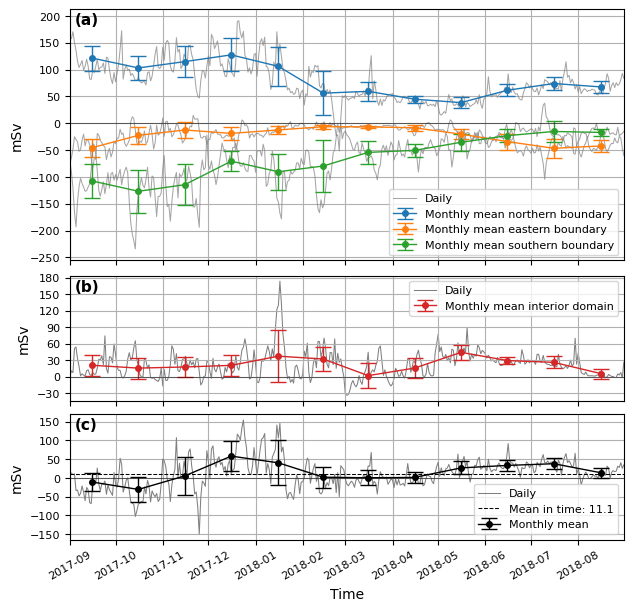

In [109]:
# Set default font size to match LaTeX document
plt.rcParams.update({
    'font.size': 11,       # Default text size
    'axes.titlesize': 10,  # Title size
    'axes.labelsize': 10,  # Axis label size
    'xtick.labelsize': 8, # X-tick label size
    'ytick.labelsize': 8, # Y-tick label size
    'legend.fontsize': 8, # Legend font size
    'figure.titlesize': 12 # Figure title size
})

fig, axs = plt.subplot_mosaic([[0],
                               [3],
                               [4]],
                               gridspec_kw={'height_ratios': [0.5, 0.25, 0.25]},
                               figsize=(6.2217, 6), sharex=True, layout='constrained')


axs[0].plot(north_d.time, -north_d * 1000, linewidth=0.75, color='grey', alpha=0.7, label='Daily')
# axs[0].plot(north_m.time, -north_m * 1000, linestyle= '-', marker='o')
axs[0].errorbar(err_north.time.values, -north_m * 1000,yerr=err_north.values,fmt='o-',markersize=4,linewidth=1, capsize=6, label='Monthly mean northern boundary')

axs[0].plot(shelfExtended_d.time, -shelfExtended_d * 1000 - shelfExtendedKogur_d * 1000, linewidth=0.75, color='grey', alpha=0.7)
axs[0].errorbar(err_shelfbreak.time.values, -shelfbreak_m * 1000,yerr=err_shelfbreak.values,fmt='o-',markersize=4,linewidth=1, capsize=6, label='Monthly mean eastern boundary')

axs[0].plot(kogur_d.time, kogur_d * 1000, linewidth=0.75, color='grey', alpha=0.7)
# axs[0].plot(kogur_m.time, kogur_m * 1000, linestyle='-', marker='o', alpha=0.7, label='')
axs[0].errorbar(err_kogur.time.values, kogur_m * 1000,yerr=err_kogur.values,fmt='o-',markersize=4,linewidth=1, capsize=6, label='Monthly mean southern boundary')

axs[0].plot(Bud_tot_d.time, [0 for i in Bud_tot_d.time], color='black', linestyle='-', linewidth=0.75, alpha=0.5)
# axs[0].set_title('a) Advective FW transports',fontweight='bold')
axs[0].annotate(text='(a)',xy=[kogur_d.time[3],185],fontweight='bold')
axs[0].set_ylabel('mSv')
axs[0].set_yticks([-250,-200,-150,-100,-50,0,50,100,150,200])
axs[0].tick_params(axis='both')
axs[0].grid()
axs[0].legend()

axs[3].plot(FW_input_d.time, FW_input_d, zorder=0, linewidth=0.75, color='grey', label='Daily')
axs[3].errorbar(err_FW_input.time.values, FW_input_m,yerr=err_FW_input.values,fmt='o-', color='C3',markersize=4,linewidth=1, capsize=6, label='Monthly mean interior domain')

axs[3].plot(Bud_tot_d.time, [0 for i in Bud_tot_d.time], color='black', linestyle='-', linewidth=0.75, alpha=0.5)
# axs[3].set_title('b) Interior FW',fontweight='bold')
axs[3].annotate(text='(b)',xy=[kogur_d.time[3],155],fontweight='bold')
axs[3].set_ylabel('mSv')
axs[3].tick_params(axis='both')
axs[3].set_yticks([-30,0,30,60,90,120,150,180])
axs[3].grid()
axs[3].legend()

axs[4].plot(Bud_tot_d.time, Bud_tot_d, linewidth=0.75, color='grey', label='Daily')
# axs[4].plot(Bud_tot_m.time, Bud_tot_m, 'r-o', label='Sum FW budget monthly')
axs[4].plot(Bud_tot_d.time, [mean_Bud for i in Bud_tot_d.time], color='black', linestyle='--', linewidth=0.75, label=f'Mean in time: {np.round(mean_Bud.values, 1)}')
axs[4].errorbar(err_Bud.time.values, Bud_tot_m,yerr=err_Bud.values,fmt='o-', color='black',markersize=4,linewidth=1, capsize=6, label='Monthly mean')

axs[4].plot(Bud_tot_d.time, [0 for i in Bud_tot_d.time], color='black', linestyle='-', linewidth=0.75, alpha=0.5)
# axs[4].set_title('c) Sum FW budget',fontweight='bold')
axs[4].annotate(text='(c)',xy=[kogur_d.time[3],130],fontweight='bold')
axs[4].set_xlabel('Time')
axs[4].set_ylabel('mSv')
axs[4].tick_params(axis='both')
axs[4].set_yticks([-150,-100,-50,0,50,100,150])
axs[4].set_xlim(kogur_d.time[0],kogur_d.time[-1])
plt.xticks(rotation=30)
axs[4].grid()
axs[4].legend()

fig.show()

fig.savefig(r'/nird/home/ekv036/MSc/Fig/FW_budget_time2',dpi=300, facecolor='w', edgecolor='w',
          orientation='landscape', format=None,
          transparent=False, bbox_inches='tight',pad_inches=0.25)


In [110]:
mean_North = -north_d.mean(dim='time').values*1000
mean_Shelfbreak = -shelfbreak_d.mean(dim='time').values*1000
mean_kogur = kogur_d.mean(dim='time').values*1000
mean_FW_int = FW_input_d.mean(dim='time').values
budget_cumsum = Bud_tot_d.mean(dim='time')
print(f'''
North: {np.round(mean_North,1)} +/- {np.round(north_m.std().values*1000,1)}
Shelfbreak: {np.round(mean_Shelfbreak,1)} +/- {np.round(shelfbreak_m.std().values*1000,1)}
Kögur: {np.round(mean_kogur,1)} +/- {np.round(kogur_m.std().values*1000,1)}
Interior: {np.round(mean_FW_int,1)} +/- {np.round(FW_input_m.std().values,1)}
Budget mean sum: {np.round(budget_cumsum.values,1)} +/- {np.round(Bud_tot_d.std().values,1)}
''')


North: 77.5 +/- 30.1
Shelfbreak: -22.7 +/- 14.6
Kögur: -65.6 +/- 37.3
Interior: 21.9 +/- 11.8
Budget mean sum: 11.1 +/- 40.5



In [111]:
cond = north_r >= 0
exp_North = north_r.where(cond)
expErr_North = exp_North.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring').std(dim='time')*1000
exp_North = exp_North.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring').mean(dim='time')*-1000

cond = north_r <= 0
imp_North = north_r.where(cond)
impErr_North = imp_North.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring').std(dim='time')*1000
imp_North = imp_North.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring').mean(dim='time')*-1000

cond = shelfExtended_r >= 0
exp_shelfExtended = shelfExtended_r.where(cond)
expErr_shelfEx = exp_shelfExtended.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring')*-1000
exp_shelfExtended = exp_shelfExtended.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring').mean(dim='time')*-1000
cond = shelfExtendedKogur_r >= 0
exp_shelfExtendedKogur = shelfExtendedKogur_r.where(cond)
expErr_shelfExKogur = exp_shelfExtendedKogur.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring')*-1000
exp_shelfExtendedKogur = exp_shelfExtendedKogur.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring').mean(dim='time')*-1000
expErr_shelf = expErr_shelfEx + expErr_shelfExKogur
expErr_shelf = expErr_shelf.std(dim='time')

cond = shelfExtended_r <= 0
imp_shelfExtended = shelfExtended_r.where(cond)
impErr_shelfEx = imp_shelfExtended.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring')*-1000
imp_shelfExtended = imp_shelfExtended.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring').mean(dim='time')*-1000
cond = shelfExtendedKogur_r <= 0
imp_shelfExtendedKogur = shelfExtendedKogur_r.where(cond)
impErr_shelfExKogur = imp_shelfExtendedKogur.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring')*-1000
imp_shelfExtendedKogur = imp_shelfExtendedKogur.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring').mean(dim='time')*-1000
impErr_shelf = impErr_shelfEx + impErr_shelfExKogur
impErr_shelf = impErr_shelf.std(dim='time')

cond = kogur_r <= 0
exp_Kogur = kogur_r.where(cond)
expErr_kogur = exp_Kogur.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring').std(dim='time')*1000
exp_Kogur = exp_Kogur.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring').mean(dim='time')*1000

cond = kogur_r >= 0
imp_Kogur = kogur_r.where(cond)
impErr_kogur = imp_Kogur.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring').std(dim='time')*1000
imp_Kogur = imp_Kogur.mean(dim='path').sel(Y=0).sel(X=0).sum(dim='Z').sum(dim='mooring').mean(dim='time')*1000

cond = FW_input <= 0
exp_Int = FW_input.where(cond)
expErr_Int = exp_Int.sum(dim='X').sum(dim='Y').std(dim='time')
exp_Int = exp_Int.sum(dim='X').sum(dim='Y').mean(dim='time')

cond = FW_input >= 0
imp_Int = FW_input.where(cond)
impErr_Int = imp_Int.sum(dim='X').sum(dim='Y').std(dim='time')
imp_Int = imp_Int.sum(dim='X').sum(dim='Y').mean(dim='time')

print(f'''
Northern transect: Import={np.round(imp_North.values,1)} +/- {np.round(impErr_North.values,1)}, Export={np.round(exp_North.values,1)} +/- {np.round(expErr_North.values,1)}, Net={np.round(imp_North.values+exp_North.values,1)} +/- {np.round(np.sqrt(impErr_North.values**2 + expErr_North.values**2),1)} 
ShelfExtended transect: Import={np.round(imp_shelfExtended.values+imp_shelfExtendedKogur.values,1)} +/- {np.round(impErr_shelf.values,1)}, Export={np.round(exp_shelfExtended.values+exp_shelfExtendedKogur.values,1)} +/- {np.round(expErr_shelf.values,1)}, Net={np.round(imp_shelfExtended.values+imp_shelfExtendedKogur.values+exp_shelfExtended.values+exp_shelfExtendedKogur.values,1)} +/- {np.round(np.sqrt(impErr_shelf.values**2+expErr_shelf.values**2),1)}
Kögur transect: Import={np.round(imp_Kogur.values,1)} +/- {np.round(impErr_kogur.values,1)}, Export={np.round(exp_Kogur.values,1)} +/- {np.round(expErr_kogur.values,1)}, Net={np.round(imp_Kogur.values+exp_Kogur.values,1)} +/- {np.round(np.sqrt(impErr_kogur.values**2+expErr_kogur.values**2),1)}
Interior: Import={np.round(imp_Int.values,1)} +/- {np.round(impErr_Int.values)}, Export={np.round(exp_Int.values)} +/- {np.round(expErr_Int.values)}, Net={np.round(imp_Int.values+exp_Int.values,1)} +/- {np.round(np.sqrt(impErr_Int.values**2+expErr_Int.values**2))}     
      ''')


Northern transect: Import=150.1 +/- 33.6, Export=-72.4 +/- 20.8, Net=77.7 +/- 39.5 
ShelfExtended transect: Import=24.8 +/- 18.2, Export=-47.5 +/- 31.2, Net=-22.7 +/- 36.1
Kögur transect: Import=88.1 +/- 50.3, Export=-153.7 +/- 65.0, Net=-65.6 +/- 82.2
Interior: Import=31.1 +/- 25.0, Export=-9.0 +/- 11.0, Net=21.9 +/- 28.0     
      


In [112]:
print('Sum Import= ',np.round(imp_Int.values+imp_Kogur.values+imp_North.values+imp_shelfExtended.values+imp_shelfExtendedKogur.values,1),' +/- ',np.round(np.sqrt(impErr_Int.values**2+impErr_kogur.values**2+impErr_North.values**2+impErr_shelf.values**2),1))
print('Sum Export= ',np.round(exp_Int.values+exp_Kogur.values+exp_North.values+exp_shelfExtended.values+exp_shelfExtendedKogur.values,1),' +/- ',np.round(np.sqrt(expErr_Int.values**2+expErr_kogur.values**2+expErr_North.values**2+expErr_shelf.values**2),1))

Sum Import=  294.0  +/-  68.0
Sum Export=  -282.7  +/-  75.8


# Investigation of interior domain spike

<xarray.DataArray ()>
array(181.05035394)
Coordinates:
    time     datetime64[ns] 2018-01-17T18:00:00


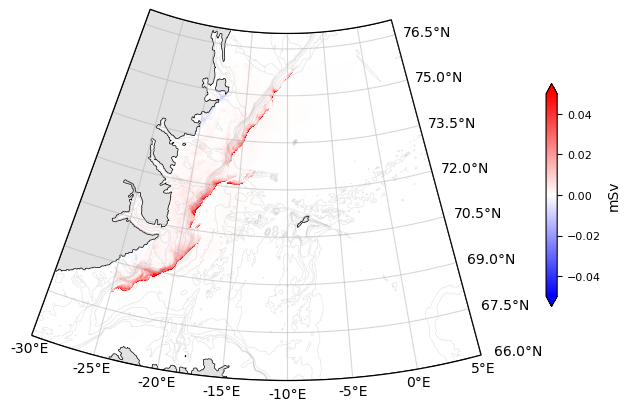

In [159]:
interior_domain_spike = FW_input.sel(time='2018-01-17T18:00:00')
print(interior_domain_spike.sum())

# Create a figure and axis with Cartopy using NorthPolarStereo projection
fig, ax = plt.subplots(figsize=(6.2217, 4), subplot_kw=dict(projection=ccrs.NorthPolarStereo(central_longitude=-10)), layout='constrained')

# Set the extent to focus on the desired geographical area
extent = [-30+10, 5+10, 66, 77]

# Example data for testing
lon = depth['XC']
lat = depth['YC']
cmap = plt.get_cmap('bwr')
mesh = ax.pcolormesh(interior_domain_spike.X, interior_domain_spike.Y, interior_domain_spike, cmap=cmap,vmin=-0.05,vmax=0.05, transform=ccrs.PlateCarree())
cbar = fig.colorbar(mesh, shrink=0.6, pad=0.005, extend='both')
cbar.set_label('mSv')

land = depth_no_nan.where(depth_no_nan==0)

ax.pcolormesh(land.X,land.Y,land,cmap='Greys',vmin=-25,vmax=100, transform=ccrs.PlateCarree())

# Add land contour
ax.contour(lon, lat, depth_no_nan, [0], colors='black', linewidths=0.5, transform=ccrs.PlateCarree())
ax.contour(lon, lat, depth_no_nan, [300,400,500,750,1000,1500,2000], colors='grey', linewidths=0.5,alpha=0.2, transform=ccrs.PlateCarree())


# Create a custom path for the extent in PlateCarree projection
num_points = 100
bottom_lons = np.linspace(extent[0], extent[1], num_points)
top_lons = np.linspace(extent[1], extent[0], num_points)
bottom_lats = np.full_like(bottom_lons, extent[2])
top_lats = np.full_like(top_lons, extent[3])

# Combine the vertices
verts = np.vstack([
    np.column_stack([bottom_lons, bottom_lats]),
    np.column_stack([top_lons, top_lats])
])

# Transform the vertices to the NorthPolarStereo projection
proj = ccrs.NorthPolarStereo()
verts_proj = proj.transform_points(ccrs.PlateCarree(), verts[:, 0], verts[:, 1])
verts_proj = verts_proj[:, :2]  # Only keep x and y coordinates

# Create the path
codes = [Path.MOVETO] + [Path.LINETO] * (len(verts_proj) - 1) + [Path.CLOSEPOLY]
path = Path(np.vstack([verts_proj, verts_proj[0]]), codes)
patch = PathPatch(path, transform=ax.transData, edgecolor='black', facecolor='none')
ax.add_patch(patch)

# Set the boundary using the transformed path
ax.set_boundary(patch.get_path(), transform=ax.transData)

# Add gridlines without labels
gl = ax.gridlines(draw_labels=False,alpha=0.5)

# Manually add the labels for the bottom and right sides
xticks = np.arange(extent[0]-10, extent[1]-10 + 1, 5)  # Adjust the range and step as needed
yticks = np.arange(extent[2], extent[3] + 1, 1.5)  # Adjust the range and step as needed

# Add bottom labels
for xtick in xticks:
    ax.text(xtick, extent[2]-0.2, f'{xtick}°E', transform=ccrs.PlateCarree(),
            fontsize=10, ha='center', va='top')

# Add right labels
for ytick in yticks:
    ax.text(extent[1] + 1-10, ytick, f'{ytick}°N', transform=ccrs.PlateCarree(),
            fontsize=10, ha='left', va='center')


# Save the figure
fig.savefig(r'/nird/home/ekv036/MSc/Fig/Interior_Spike',dpi=300, facecolor='w', edgecolor='w',
          orientation='landscape', format=None,
          transparent=False, bbox_inches=None,pad_inches=0.25)

In [162]:
ATM_Temp = xr.open_dataset('/nird/projects/NS9608K/MSc_EK/Data/2mATMTemp.nc')['EXFatemp']
display(ATM_Temp)

<xarray.DataArray 'EXFatemp' (time: 2, Y: 518, X: 385)>
[398860 values with dtype=float64]
Coordinates:
  * X        (X) float64 -26.96 -26.89 -26.83 -26.76 ... -8.094 -8.051 -8.007
  * Y        (Y) float64 66.01 66.02 66.04 66.05 ... 75.87 75.91 75.95 75.99
    XC       (Y, X) float64 ...
    YC       (Y, X) float64 ...
  * time     (time) datetime64[ns] 2018-01-17T12:00:00 2018-01-17T18:00:00
Attributes:
    description:    surface (2-m) air temperature
    units:          degK
    standard_name:  EXFatemp
    long_name:      surface (2-m) air temperature

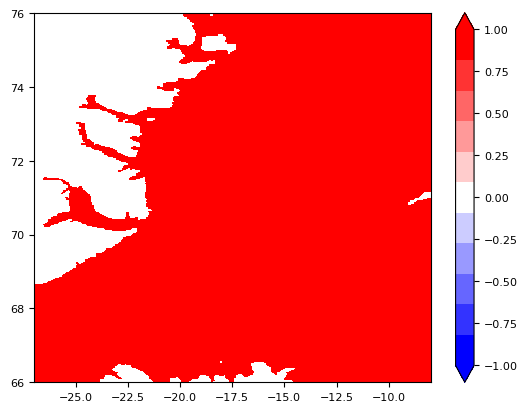

In [183]:
fig, ax = plt.subplots()
cmap = plt.get_cmap('bwr')
mesh = ax.pcolormesh(ATM_Temp.X,ATM_Temp.Y,ATM_Temp[0]/273.15,cmap=cmap.resampled(11),vmin=-1,vmax=1)
cbar = fig.colorbar(mesh,extend='both')